In [1]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_ = pd.read_excel("datasets/online_retail_II.xlsx", sheet_name="Year 2009-2010")
df = df_.copy()

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df = df[~df["Invoice"].str.contains("C", na=False)]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,515255.0,10.956631,104.354013,-9600.00,1.00,3.0,10.00,19152.00
Price,515255.0,3.956373,127.688563,-53594.36,1.25,2.1,4.21,25111.09
Customer ID,407695.0,15368.504107,1679.795700,12346.00,13997.00,15321.0,16812.00,18287.00


In [5]:
df = df[(df['Quantity'] > 0)]
df.dropna(inplace=True)

In [6]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [7]:
cltv_c = df.groupby('Customer ID').agg({'Invoice': lambda x: x.nunique(),
                                        'Quantity': lambda x: x.sum(),
                                        'TotalPrice': lambda x: x.sum()})

cltv_c.columns = ['total_transaction', 'total_unit', 'total_price']

In [8]:
cltv_c["average_order_value"] = cltv_c["total_price"] / cltv_c["total_transaction"]

In [9]:
cltv_c["purchase_frequency"] = cltv_c["total_transaction"] / cltv_c.shape[0]

In [10]:
repeat_rate = cltv_c[cltv_c["total_transaction"] > 1].shape[0] / cltv_c.shape[0]
churn_rate = 1 - repeat_rate

In [11]:
cltv_c['profit_margin'] = cltv_c['total_price'] * 0.10

In [12]:
cltv_c['customer_value'] = cltv_c['average_order_value'] * cltv_c["purchase_frequency"]

In [13]:
cltv_c["cltv"] = (cltv_c["customer_value"] / churn_rate) * cltv_c["profit_margin"]

In [14]:
cltv_c.sort_values(by="cltv", ascending=False).head()

,total_transaction,total_unit,total_price,average_order_value,purchase_frequency,profit_margin,customer_value,cltv
Customer ID,,,,,,,,
18102.0,89,124216,349164.35,3923.194944,0.020631,34916.435,80.937494,8.579574e+06
14646.0,78,170342,248396.50,3184.570513,0.018081,24839.650,57.579161,4.342070e+06
14156.0,102,108107,196566.74,1927.124902,0.023644,19656.674,45.564845,2.719105e+06
14911.0,205,69722,152147.57,742.183268,0.047520,15214.757,35.268329,1.629056e+06
13694.0,94,125893,131443.19,1398.331809,0.021790,13144.319,30.468982,1.215856e+06


In [15]:
cltv_c["segment"] = pd.qcut(cltv_c["cltv"], 4, labels=["D", "C", "B", "A"])
cltv_c.sort_values(by="cltv", ascending=False).head()
cltv_c.groupby("segment").agg({"count", "mean", "sum"})

total_transaction                   total_unit                        \
                    count       mean    sum      count         mean      sum   
segment                                                                        
D                    1079   1.228916   1326       1079   109.004634   117616   
C                    1078   2.003711   2160       1078   283.056586   305135   
B                    1078   3.769017   4063       1078   680.158627   733211   
A                    1079  10.811863  11666       1079  4062.337349  4383262   

        total_price                           average_order_value  ...  \
              count         mean          sum               count  ...   
segment                                                            ...   
D              1079   178.188258   192265.130                1079  ...   
C              1078   475.896524   513016.453                1078  ...   
B              1078  1131.359184  1219605.200                1078  ...   
A              1079  6401.405460  6907116.491                1079  ...   

        purchase_frequency profit_margin                           \
                       sum         count        mean          sum   
segment                                                             
D                 0.307371          1079   17.818826   19226.5130   
C                 0.500695          1078   47.589652   51301.6453   
B                 0.941817          1078  113.135918  121960.5200   
A                 2.704219          1079  640.140546  690711.6491   

        customer_value                         cltv                \
                 count      mean          sum count          mean   
segment                                                             
D                 1079  0.041305    44.567717  1079      2.640712   
C                 1078  0.110314   118.918974  1078     16.868519   
B                 1078  0.262253   282.708669  1078     96.057387   
A                 1079  1.483868  1601.093299  1079  23408.058426   

                       
                  sum  
segment                
D        2.849328e+03  
C        1.818426e+04  
B        1.035499e+05  
A        2.525730e+07  

[4 rows x 24 columns]

In [16]:
##Prediction

In [17]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [18]:
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [19]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [20]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
today_date = dt.datetime(2011, 12, 11)
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2.0,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1.0,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1.0,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2.0,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,7.50


In [21]:
cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4312.0,133.998609,132.827183,0.00,0.00000,105.000,254.000000,373.000
T,4312.0,590.496985,118.909803,366.00,482.00000,618.000,694.000000,739.000
frequency,4312.0,4.455705,8.170213,1.00,1.00000,2.000,5.000000,205.000
monetary,4312.0,358.643179,347.720612,2.95,178.47875,283.171,418.890625,5633.465


In [22]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [23]:
#BG-NBD model
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 1.93, alpha: 9.47, b: 6.27, r: 2.22>

In [24]:
#A week
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
15989.0    0.007560
16720.0    0.007216
14119.0    0.007197
16204.0    0.007153
17591.0    0.007135
15169.0    0.006998
17193.0    0.006977
17251.0    0.006959
17411.0    0.006902
17530.0    0.006798
dtype: float64

In [25]:
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
15989.0    0.007560
16720.0    0.007216
14119.0    0.007197
16204.0    0.007153
17591.0    0.007135
15169.0    0.006998
17193.0    0.006977
17251.0    0.006959
17411.0    0.006902
17530.0    0.006798
dtype: float64

In [26]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [27]:
#A month
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12346.0,28.000000,103.714286,11,33.896364,4.383927e-07,0.000002
12347.0,5.285714,57.857143,2,661.660000,3.831649e-04,0.001500
12349.0,25.857143,84.285714,3,765.006667,1.412075e-03,0.005554
12352.0,2.285714,56.142857,2,171.900000,1.684685e-04,0.000659
12356.0,6.285714,60.714286,3,1187.416667,1.290079e-04,0.000505
...,...,...,...,...,...,...
18276.0,48.000000,104.285714,5,264.132000,2.332672e-03,0.009186
18277.0,13.857143,70.714286,4,256.665000,1.698766e-04,0.000665
18283.0,39.285714,94.142857,6,106.961667,9.240984e-04,0.003631


In [28]:
#Mean
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

11.608238398752182

In [29]:
#Expected Number of Sales in 3 Months
bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

33.45022301470142

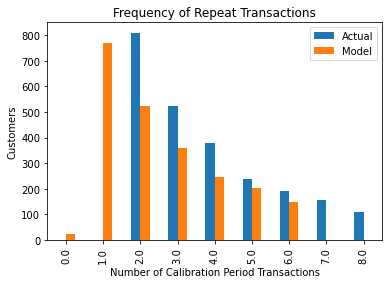

In [30]:
#Evaluation of Forecasts
plot_period_transactions(bgf)
plt.show()

In [31]:
#Gamma-gamma
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
Customer ID,,,,,,,
12357.0,0.000000,55.571429,2,5633.465000,7.087625e-05,2.772510e-04,6172.345889
17450.0,10.000000,62.714286,7,5321.585000,4.538282e-06,1.768083e-05,5457.788339
14091.0,6.285714,99.857143,2,4584.045000,4.050678e-05,1.598720e-04,5022.921645
14088.0,2.000000,60.285714,3,4512.990000,2.556784e-05,9.998788e-05,4792.191502
18102.0,53.285714,105.571429,89,3526.442416,3.750554e-23,1.465476e-22,3533.392573
12409.0,20.571429,80.857143,4,3086.655000,3.461201e-04,1.358884e-03,3228.011340
14646.0,51.714286,105.428571,78,3108.767179,3.310913e-21,1.293861e-20,3115.765818
12454.0,3.571429,60.285714,4,2811.445000,1.247881e-05,4.872953e-05,2940.284688
16684.0,50.285714,104.714286,27,2847.767037,2.567022e-08,1.005072e-07,2866.378091


In [32]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 month
                                   freq="W",  # T
                                   discount_rate=0.01)

In [33]:
cltv = cltv.reset_index()
cltv.head()

,Customer ID,clv
0,12346.0,0.000181
1,12347.0,3.275062
2,12349.0,13.746351
3,12352.0,0.376328
4,12356.0,1.908140


In [34]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv
67,12497.0,34.857143,92.142857,2,2563.820000,0.004208,0.016593,2810.179757,142.887244
1671,15823.0,51.142857,104.571429,3,1292.050000,0.006209,0.024494,1372.925477,103.179795
83,12557.0,50.142857,103.285714,4,1681.295000,0.004576,0.018030,1758.735051,96.999557
1059,14564.0,42.857143,105.142857,2,1302.810000,0.004429,0.017490,1429.002092,76.937065
6,12358.0,50.857143,104.571429,3,901.236667,0.006078,0.023977,958.048219,70.479500
449,13373.0,45.285714,104.857143,3,1424.980000,0.003814,0.015045,1514.040503,69.893998
58,12477.0,31.857143,89.142857,3,2352.210000,0.002297,0.009041,2498.363724,68.887943
2127,16732.0,46.857143,104.571429,3,1175.276667,0.004426,0.017458,1248.961947,66.898698
42,12435.0,48.571429,105.428571,4,1460.222500,0.003454,0.013613,1527.608093,63.658485
221,12873.0,40.571429,97.428571,2,826.650000,0.005206,0.020540,907.466532,57.230185


In [35]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.sort_values(by="clv", ascending=False).head(50)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit,clv,segment
67,12497.0,34.857143,92.142857,2,2563.820000,0.004208,0.016593,2810.179757,142.887244,A
1671,15823.0,51.142857,104.571429,3,1292.050000,0.006209,0.024494,1372.925477,103.179795,A
83,12557.0,50.142857,103.285714,4,1681.295000,0.004576,0.018030,1758.735051,96.999557,A
1059,14564.0,42.857143,105.142857,2,1302.810000,0.004429,0.017490,1429.002092,76.937065,A
6,12358.0,50.857143,104.571429,3,901.236667,0.006078,0.023977,958.048219,70.479500,A
449,13373.0,45.285714,104.857143,3,1424.980000,0.003814,0.015045,1514.040503,69.893998,A
58,12477.0,31.857143,89.142857,3,2352.210000,0.002297,0.009041,2498.363724,68.887943,A
2127,16732.0,46.857143,104.571429,3,1175.276667,0.004426,0.017458,1248.961947,66.898698,A
42,12435.0,48.571429,105.428571,4,1460.222500,0.003454,0.013613,1527.608093,63.658485,A
221,12873.0,40.571429,97.428571,2,826.650000,0.005206,0.020540,907.466532,57.230185,A


In [36]:
cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})

Customer ID                           recency             \
              count          mean         sum   count       mean   
segment                                                            
D               724  15506.726519  11226870.0     724  22.717048   
C               723  15325.250346  11080156.0     723  23.359218   
B               723  15349.189488  11097464.0     723  30.214582   
A               723  15222.006916  11005511.0     723  37.845287   

                          T                          frequency  ...  \
                  sum count       mean           sum     count  ...   
segment                                                         ...   
D        16447.142857   724  87.959353  63682.571429       724  ...   
C        16888.714286   723  84.997234  61453.000000       723  ...   
B        21845.142857   723  89.848449  64960.428571       723  ...   
A        27362.142857   723  95.340842  68931.428571       723  ...   

        expected_purc_1_week expected_purc_1_month                      \
                         sum                 count      mean       sum   
segment                                                                  
D                   0.025234                   724  0.000137  0.099059   
C                   0.199296                   723  0.001083  0.783037   
B                   0.695820                   723  0.003786  2.737323   
A                   2.027348                   723  0.011050  7.988819   

        expected_average_profit                              clv             \
                          count        mean            sum count       mean   
segment                                                                       
D                           724  338.032356  244735.425590   724   0.081883   
C                           723  351.796299  254348.723915   723   0.792449   
B                           723  389.178425  281376.001442   723   3.131898   
A                           723  498.258863  360241.157640   723  14.401344   

                       
                  sum  
segment                
D           59.283604  
C          572.940919  
B         2264.362399  
A        10412.171787  

[4 rows x 27 columns]